In [ ]:
# Colab cell (bash)
!pip install -q transformers datasets accelerate sentencepiece tokenizers wandb
!pip install -q sentence-transformers # optional if you plan to compute alternate embeddings


In [ ]:
# Python cell
import os
import re
import json
from pathlib import Path
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from transformers import DistilBertTokenizerFast

# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Mounted at /content/drive
Device: cuda


In [ ]:
# Python cell - adjust paths to your files
DRIVE_ROOT = Path("/content/drive/MyDrive/datasets")
train_path = DRIVE_ROOT / "Mercor_dataset" / "train.csv"   # MODIFY if different
test_path  = DRIVE_ROOT / "Mercor_dataset" / "test.csv"    # optional

train_df = pd.read_csv(train_path)
print("Train shape:", train_df.shape)
train_df.head(3)


Train shape: (269, 4)


,id,topic,answer,is_cheating
0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1
1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0
2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1


In [ ]:
# Python cell
# Print columns & sample
print("Columns:", train_df.columns.tolist())
print("\nSample text:\n", train_df['answer'].iloc[0][:600])

# Basic class balance (if label exists)
if 'label' in train_df.columns:
    print("\nLabel distribution:\n", train_df['label'].value_counts(normalize=False))
elif 'target' in train_df.columns:
    print("\nTarget distribution:\n", train_df['target'].value_counts())
else:
    print("\nNo obvious label column found. Check column names.")

# Topic counts if available
if 'topic' in train_df.columns:
    print("\nUnique topics:", train_df['topic'].nunique())
    print("Top topics:\n", train_df['topic'].value_counts().head())


Columns: ['id', 'topic', 'answer', 'is_cheating']

Sample text:
 My eyes flew open, and the air around me feels colder than it should. For a moment I'm not sure where I am. I can still smell the sea air, and feel the icy rain blasting agains my face. He had been there beside me, sharp blue eyes, and long hair blowing in the storm. 

I blink again and wrap my blanket tighter around me as I take in the room. My oak nightstand sits beside me, a glass of water with my phone placed next to it. The alarm has yet to go off. Outside my window the sky is gray, but I can hear the first calls of the early morning birds. My husband is still asleep, and he is not the ma

No obvious label column found. Check column names.

Unique topics: 268
Top topics:
 topic
Fiction                                                       2
The Unlikely Comeback of Analog Billboards in Smart Cities    1
Social Media - Connect Us                                     1
The influence of weather on famous military blunder

In [ ]:
# Python cell
import unicodedata

def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKC", s)          # normalize unicode
    s = re.sub(r'\s+', ' ', s).strip()           # collapse whitespace
    return s

# Apply to dataframe (create a cleaned column)
train_df['answer_clean'] = train_df['answer'].astype(str).apply(normalize_text)


In [ ]:
# Python cell: robust feature extraction for your columns
import re
import unicodedata
import string
from typing import Dict
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# --- ensure normalize_text exists (redefine if not) ---
def normalize_text(s: str) -> str:
    if pd.isna(s):
        return ""
    s = str(s)
    s = unicodedata.normalize("NFKC", s)          # normalize unicode
    s = re.sub(r'\s+', ' ', s).strip()           # collapse whitespace
    return s

# --- identify text & label columns in your dataset ---
text_col = "answer"         # your text column
label_col = "is_cheating"   # your label column (0/1)

if text_col not in train_df.columns:
    raise KeyError(f"Expected text column '{text_col}' not found in train_df. Columns: {train_df.columns.tolist()}")

if label_col not in train_df.columns:
    raise KeyError(f"Expected label column '{label_col}' not found in train_df. Columns: {train_df.columns.tolist()}")

# --- create normalized text column (safe) ---
train_df['text_clean'] = train_df[text_col].astype(str).apply(normalize_text)

# --- feature extraction function ---
def extract_basic_features(text: str) -> Dict[str, float]:
    text = text or ""
    words = text.split()
    n_words = len(words)
    n_chars = len(text)
    # simple sentences estimate
    n_sentences = max(1, text.count('.') + text.count('!') + text.count('?')) if n_chars > 0 else 0
    avg_word_len = float(np.mean([len(w) for w in words])) if words else 0.0
    unique_ratio = float(len(set(words)) / n_words) if n_words > 0 else 0.0
    punctuation_counts = sum(1 for ch in text if ch in string.punctuation)
    digits_ratio = float(sum(ch.isdigit() for ch in text) / n_chars) if n_chars > 0 else 0.0
    comma_ratio = float(text.count(',') / n_chars) if n_chars > 0 else 0.0

    return {
        "n_words": n_words,
        "n_chars": n_chars,
        "n_sentences": n_sentences,
        "avg_word_len": avg_word_len,
        "unique_ratio": unique_ratio,
        "punctuation_counts": punctuation_counts,
        "digits_ratio": digits_ratio,
        "comma_ratio": comma_ratio
    }

# --- apply features (fast vectorized apply) ---
# This will produce a DataFrame with one row per text
feat_df = train_df['text_clean'].apply(lambda t: pd.Series(extract_basic_features(t)))

# concat features into original df
train_df = pd.concat([train_df.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)

# --- label encoding (ensures 0/1 numeric label) ---
# if labels are already 0/1, this is harmless; otherwise it maps string labels
if train_df[label_col].dtype.kind in ('i','f'):  # numeric already
    train_df['label_enc'] = train_df[label_col].astype(int)
else:
    le = LabelEncoder()
    train_df['label_enc'] = le.fit_transform(train_df[label_col].astype(str))

# --- quick checks ---
print("Resulting columns (sample):", train_df.columns.tolist())
print("\nLabel distribution:\n", train_df['label_enc'].value_counts())
print("\nFeature sample:\n", train_df.loc[:, ['id','topic','text_clean','n_words','n_chars','unique_ratio','punctuation_counts','label_enc']].head(5))


Resulting columns (sample): ['id', 'topic', 'answer', 'is_cheating', 'answer_clean', 'text_clean', 'n_words', 'n_chars', 'n_sentences', 'avg_word_len', 'unique_ratio', 'punctuation_counts', 'digits_ratio', 'comma_ratio', 'label_enc']

Label distribution:
 label_enc
1    147
0    122
Name: count, dtype: int64

Feature sample:
                  id                                              topic  \
0  scr_cd3edac7d322  A girl wakes from a dream and she is not sure ...   
1  scr_86f1104afb28  A journalistic review piece about the top 6 ai...   
2  scr_c461dafbe886  The influence of fictional universities in cam...   
3  scr_64880cce429f                           Why do girls love horses   
4  scr_c7742a3b2444  Every year, a remote mountain town elects a ne...   

                                          text_clean  n_words  n_chars  \
0  My eyes flew open, and the air around me feels...    183.0    870.0   
1  Robot Butlers in the year of 2025. What are th...     63.0    315.0   
2  In

In [ ]:
# Python cell: label encoding (idempotent)
from sklearn.preprocessing import LabelEncoder

text_col = "text_clean"    # we created this earlier from 'answer'
label_col = "is_cheating"  # original label column
enc_col = "label_enc"

if enc_col not in train_df.columns:
    if train_df[label_col].dtype.kind in ('i','f'):
        train_df[enc_col] = train_df[label_col].astype(int)
    else:
        le = LabelEncoder()
        train_df[enc_col] = le.fit_transform(train_df[label_col].astype(str))
else:
    # ensure integer type
    train_df[enc_col] = train_df[enc_col].astype(int)

print("Label distribution (label_enc):")
print(train_df[enc_col].value_counts())


Label distribution (label_enc):
label_enc
1    147
0    122
Name: count, dtype: int64


In [ ]:
# Python cell: grouped split using GroupKFold
from sklearn.model_selection import GroupKFold

# ensure topic exists
if 'topic' not in train_df.columns:
    raise KeyError("Column 'topic' not found. Please ensure your DataFrame has a 'topic' column.")

train_df = train_df.reset_index(drop=True)  # safe reset
n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

# create fold column if not exists
if 'fold' not in train_df.columns:
    train_df['fold'] = -1
    groups = train_df['topic'].values
    for fold, (tr_idx, val_idx) in enumerate(gkf.split(X=train_df, y=train_df[enc_col], groups=groups)):
        train_df.loc[val_idx, 'fold'] = fold

# choose one fold for quick experiments (fold 0 as validation)
chosen_fold = 0
train_split = train_df[train_df['fold'] != chosen_fold].reset_index(drop=True)
val_split   = train_df[train_df['fold'] == chosen_fold].reset_index(drop=True)

print(f"Total rows: {len(train_df)}; Train: {len(train_split)}; Val: {len(val_split)}")
print("Topic counts in train (top 5):")
print(train_split['topic'].value_counts().head())
print("Topic counts in val (top 5):")
print(val_split['topic'].value_counts().head())


Total rows: 269; Train: 215; Val: 54
Topic counts in train (top 5):
topic
A girl wakes from a dream and she is not sure if it is real                                                        1
A journalistic review piece about the top 6 ai robot butlers available on the market                               1
The influence of fictional universities in campus clothing sales                                                   1
Every year, a remote mountain town elects a new “Keeper of the Fog,” who must spend winter alone atop the peak.    1
True paranormal story from my childhood- the picture frame                                                         1
Name: count, dtype: int64
Topic counts in val (top 5):
topic
Fiction                                                                                                                                                                                                                                                               2
A social media c

In [ ]:
# Python cell: tokenizer setup
from transformers import DistilBertTokenizerFast

MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

# quick check: tokens length stats to decide chunking
def token_length_stats(texts, tokenizer, sample_n=1000):
    sample = texts.sample(min(len(texts), sample_n), random_state=42)
    lens = [len(tokenizer(t, add_special_tokens=True)['input_ids']) for t in sample]
    return {
        'min': int(np.min(lens)),
        'q25': int(np.percentile(lens,25)),
        'median': int(np.median(lens)),
        'q75': int(np.percentile(lens,75)),
        'max': int(np.max(lens))
    }

stats = token_length_stats(train_df[text_col], tokenizer, sample_n=1000)
print("Token length stats (sample):", stats)

# tokenization helper (batch)
MAX_LEN = 512
def tokenize_texts(texts, max_length=MAX_LEN, padding='max_length', truncation=True, return_tensors='pt'):
    """
    texts: list[str] or pandas Series
    returns: dict of tensors if return_tensors specified (default 'pt')
    """
    return tokenizer(
        list(texts),
        padding=padding,
        truncation=truncation,
        max_length=max_length,
        return_attention_mask=True,
        return_tensors=return_tensors
    )

# quick demo
sample_texts = train_split[text_col].iloc[:3].tolist()
tok_demo = tokenize_texts(sample_texts)
print("Demo tokenized shapes:", tok_demo['input_ids'].shape)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors


Token length stats (sample): {'min': 32, 'q25': 172, 'median': 202, 'q75': 219, 'max': 1359}
Demo tokenized shapes: torch.Size([3, 512])


In [ ]:
# Python cell: robust chunking helper that handles token ids correctly
from typing import List, Dict

def chunk_text_to_inputs(text: str,
                         tokenizer: DistilBertTokenizerFast,
                         max_len: int = 510,
                         stride: int = 50) -> List[Dict[str, List[int]]]:
    """
    Tokenize `text` to ids, split into overlapping chunks of token ids (no special tokens),
    then add model special tokens per chunk and return dicts with 'input_ids' and 'attention_mask'.

    - max_len: number of tokens per chunk BEFORE adding special tokens (so resulting length will be <= max_len + special_tokens)
    - stride: overlap in tokens between consecutive chunks
    """
    if text is None:
        text = ""
    # tokenize without special tokens so we control chunking on raw token ids
    enc = tokenizer(text, add_special_tokens=False)
    ids = enc.get("input_ids", [])
    # empty text -> produce one minimal encoded input (tokenizer will add special tokens)
    if len(ids) == 0:
        input_ids = tokenizer.build_inputs_with_special_tokens([])
        return [{"input_ids": input_ids, "attention_mask": [1] * len(input_ids)}]

    # short enough -> one chunk (we will add special tokens)
    if len(ids) <= max_len:
        input_ids = tokenizer.build_inputs_with_special_tokens(ids)
        return [{"input_ids": input_ids, "attention_mask": [1] * len(input_ids)}]

    # otherwise produce overlapping chunks
    chunks = []
    i = 0
    while i < len(ids):
        chunk_ids = ids[i:i + max_len]
        input_ids = tokenizer.build_inputs_with_special_tokens(chunk_ids)  # adds [CLS], [SEP], etc.
        attention_mask = [1] * len(input_ids)
        chunks.append({"input_ids": input_ids, "attention_mask": attention_mask})
        if i + max_len >= len(ids):
            break
        i += max_len - stride
    return chunks

# quick synthetic demo (should not error)
long_text = " ".join(["hello world"] * 600)
chunks = chunk_text_to_inputs(long_text, tokenizer)
print("Chunks:", len(chunks))
print("First chunk length (input_ids):", len(chunks[0]['input_ids']))
print("Sample input_ids (first 10):", chunks[0]['input_ids'][:10])


Chunks: 3
First chunk length (input_ids): 512
Sample input_ids (first 10): [101, 7592, 2088, 7592, 2088, 7592, 2088, 7592, 2088, 7592]


In [ ]:
# Python cell: automatic decision whether to chunk based on percentage > MAX_LEN
def percent_long(texts, tokenizer, max_len=512, sample_n=2000):
    sample = texts.sample(min(len(texts), sample_n), random_state=42)
    too_long = sum(1 for t in sample if len(tokenizer(t, add_special_tokens=True)['input_ids']) > max_len)
    return too_long / len(sample)

perc = percent_long(train_df[text_col], tokenizer, max_len=MAX_LEN, sample_n=2000)
print(f"Approx fraction of samples > {MAX_LEN} tokens (sample): {perc:.3f}")

# If perc is small (e.g. < 0.02) you can safely truncate. If > ~0.05 consider chunking.


Approx fraction of samples > 512 tokens (sample): 0.056


In [ ]:
# Python cell: save processed splits
OUT_DIR = DRIVE_ROOT / "mercor" / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

train_split.to_parquet(OUT_DIR / "train_split.parquet", index=False)
val_split.to_parquet(OUT_DIR / "val_split.parquet", index=False)

print("Saved train_split and val_split to:", OUT_DIR)


Saved train_split and val_split to: /content/drive/MyDrive/datasets/mercor/processed


In [ ]:
# Python cell: tokenize and create HuggingFace datasets
from datasets import Dataset, DatasetDict
import gc

# columns in your data
text_col = "text_clean"
label_col = "label_enc"

# choose truncation or chunking strategy: here we fine-tune with truncation (fast & standard).
# If you prefer to fine-tune with chunking, let me know and I'll give chunking-train code.
MAX_LEN = 512

def hf_tokenize(df):
    # tokenizer returns lists (not tensors) so datasets can convert to torch later
    toks = tokenizer(
        df[text_col].tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_attention_mask=True,
    )
    toks['label'] = df[label_col].tolist()
    toks['id'] = df['id'].tolist() if 'id' in df.columns else list(df.index)
    return Dataset.from_dict(toks)

train_hf = hf_tokenize(train_split)
val_hf   = hf_tokenize(val_split)

ds = DatasetDict({"train": train_hf, "validation": val_hf})
print(ds)
gc.collect()


DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label', 'id'],
        num_rows: 215
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'label', 'id'],
        num_rows: 54
    })
})


132

In [ ]:
# Python cell: model & metrics
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score

MODEL_NAME = "distilbert-base-uncased"
num_labels = 2

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits[:,1])) if logits.shape[1] > 1 else logits
    # if logits are of shape (n,2), compute softmax probs for positive class
    if logits.shape[1] == 2:
        from scipy.special import softmax
        probs = softmax(logits, axis=1)[:,1]
    preds = np.argmax(logits, axis=1)
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, preds)
    return {"auc": auc, "accuracy": acc}


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install -U transformers


In [ ]:
# Defensive Trainer setup cell
import torch
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from scipy.special import softmax
from datasets import DatasetDict

# sanity checks
print("Device available:", torch.cuda.is_available(), "Device:", device)
print("Type train ds:", type(ds["train"]), "Type val ds:", type(ds["validation"]))
print("Train columns:", ds["train"].column_names)

# ensure required columns exist in HF datasets
required_cols = {"input_ids", "attention_mask", "label"}
missing = required_cols - set(ds["train"].column_names)
if missing:
    raise ValueError(f"Dataset is missing required columns: {missing}. Re-tokenize so tokenized dataset contains these columns.")

# Create model (use the existing model variable if already created)
MODEL_NAME = "distilbert-base-uncased"
num_labels = 2
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

# Setup training args: disable fp16 if no CUDA
OUTPUT_DIR = "/content/drive/MyDrive/mercor/distilbert_out"
use_fp16 = torch.cuda.is_available()

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR),
    do_train=True,
    do_eval=True,
    logging_dir=f"{OUTPUT_DIR}/logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_total_limit=3,
    seed=42,
)


# Use a simple padding collator; padding=True is broadly compatible
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

# compute_metrics function (stable)
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # handle multi-dim logits
    if logits.ndim == 2 and logits.shape[1] == 2:
        probs = softmax(logits, axis=1)[:,1]
    else:
        probs = 1 / (1 + np.exp(-logits)).ravel()
    preds = np.argmax(logits, axis=1) if logits.ndim == 2 else (probs > 0.5).astype(int)
    auc = roc_auc_score(labels, probs) if len(np.unique(labels)) > 1 else 0.0
    acc = accuracy_score(labels, preds)
    return {"auc": auc, "accuracy": acc}

# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds["train"],
    eval_dataset=ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Trainer created successfully. To train, run: trainer.train()")


Device available: True Device: cuda
Type train ds: <class 'datasets.arrow_dataset.Dataset'> Type val ds: <class 'datasets.arrow_dataset.Dataset'>
Train columns: ['input_ids', 'attention_mask', 'label', 'id']


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1968380221.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Trainer created successfully. To train, run: trainer.train()


In [ ]:
# Python cell: train
trainer.train()


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qadirju12 (qadirju12-sukkur-iba-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=42, training_loss=0.5209077653430757, metrics={'train_runtime': 106.2066, 'train_samples_per_second': 6.073, 'train_steps_per_second': 0.395, 'total_flos': 85441472133120.0, 'train_loss': 0.5209077653430757, 'epoch': 3.0})

In [ ]:
# Python cell: evaluate and predict
metrics = trainer.evaluate(ds["validation"])
print("Validation metrics:", metrics)

# get raw predictions (logits) and compute probabilities
preds_out = trainer.predict(ds["validation"])
logits = preds_out.predictions
if logits.shape[1] == 2:
    from scipy.special import softmax
    probs = softmax(logits, axis=1)[:,1]
else:
    probs = 1 / (1 + np.exp(-logits))  # binary logits guard

val_ids = ds["validation"]['id']
val_labels = ds["validation"]['label']
val_df_preds = pd.DataFrame({
    "id": val_ids,
    "label": val_labels,
    "prob_pos": probs
})
val_df_preds.head()
val_df_preds.to_csv(OUTPUT_DIR + "/val_predictions.csv", index=False)
print("Saved validation predictions to", OUTPUT_DIR + "/val_predictions.csv")


Validation metrics: {'eval_loss': 0.3812217116355896, 'eval_auc': 0.9807692307692308, 'eval_accuracy': 0.9259259259259259, 'eval_runtime': 0.8748, 'eval_samples_per_second': 61.726, 'eval_steps_per_second': 2.286, 'epoch': 3.0}
Saved validation predictions to /content/drive/MyDrive/mercor/distilbert_out/val_predictions.csv


In [ ]:
# Python cell: chunk-aware predict function
import torch
from torch.nn.functional import softmax

model.eval()
model.to(device)

def predict_text_by_chunks(text: str, model, tokenizer, max_len:int=510, stride:int=50, device=device):
    """
    Splits text into chunks (based on token ids), runs model on each chunk, and returns averaged positive-class probability.
    """
    chunks = chunk_text_to_inputs(text, tokenizer, max_len=max_len, stride=stride)
    probs = []
    with torch.no_grad():
        for chunk in chunks:
            # pad single chunk to model expected length using tokenizer.pad
            batch = tokenizer.pad([chunk], return_tensors="pt")
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits.detach().cpu().numpy()
            # compute prob positive
            if logits.shape[1] == 2:
                from scipy.special import softmax as sm
                p = sm(logits, axis=1)[:,1][0]
            else:
                p = 1 / (1 + np.exp(-logits))[0]
            probs.append(p)
    # aggregate: mean; alternatives: max, weighted mean by chunk length
    if len(probs) == 0:
        return 0.5
    return float(np.mean(probs))

# demo on a long sample from val_split
sample_text = val_split[text_col].iloc[0]
p = predict_text_by_chunks(sample_text, model, tokenizer)
print("Chunk-agg pred (pos prob):", p)


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Chunk-agg pred (pos prob): 0.2852303683757782


In [ ]:
# Python cell: save final model and tokenizer
best_dir = OUTPUT_DIR + "/best_model"
trainer.save_model(best_dir)
tokenizer.save_pretrained(best_dir)
print("Saved model and tokenizer to:", best_dir)


Saved model and tokenizer to: /content/drive/MyDrive/mercor/distilbert_out/best_model


In [ ]:
# Python cell: extract pooled embeddings (fast inference mode)
from transformers import DistilBertModel
import torch

extract_model = DistilBertModel.from_pretrained(best_dir).to(device)
extract_model.eval()

def get_pooled_embeddings(texts: List[str], tokenizer, model, max_length=512, batch_size=32):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tok = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        tok = {k: v.to(device) for k,v in tok.items()}
        with torch.no_grad():
            out = model(**tok)
            # DistilBERT's pooled output is often last_hidden_state[:,0,:] (CLS token)
            pooled = out.last_hidden_state[:,0,:].detach().cpu().numpy()
        embs.append(pooled)
    return np.vstack(embs)

train_embs = get_pooled_embeddings(train_split[text_col].tolist(), tokenizer, extract_model, max_length=MAX_LEN)
val_embs   = get_pooled_embeddings(val_split[text_col].tolist(), tokenizer, extract_model, max_length=MAX_LEN)

print("Train emb shape:", train_embs.shape, "Val emb shape:", val_embs.shape)

# Save embeddings to disk for LightGBM/Ensemble later
np.save(OUTPUT_DIR + "/train_embs.npy", train_embs)
np.save(OUTPUT_DIR + "/val_embs.npy", val_embs)


Train emb shape: (215, 768) Val emb shape: (54, 768)


**Checking After Model Training**

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch
from scipy.special import softmax

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# path to your saved best model
MODEL_PATH = "/content/drive/MyDrive/mercor/distilbert_out/best_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
def predict_text(text: str, model, tokenizer, max_len: int = 512, device=device):
    """
    Predict probability of AI-generated vs human-written text.
    Returns: probability of AI-generated (label=1)
    """
    # tokenize input
    enc = tokenizer(text, truncation=True, max_length=max_len, padding="max_length", return_tensors="pt")
    enc = {k: v.to(device) for k, v in enc.items()}

    # forward pass
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits.detach().cpu().numpy()

    # convert logits to probability
    if logits.shape[1] == 2:
        probs = softmax(logits, axis=1)
        prob_ai = float(probs[:, 1][0])  # label 1 = AI-generated
    else:
        prob_ai = 1 / (1 + np.exp(-logits))[0]

    return prob_ai


In [ ]:
new_text = "This is a sample paragraph written to test the model."

prob_ai = predict_text(new_text, model, tokenizer)
print(f"Probability AI-generated: {prob_ai:.4f}")

# classify
threshold = 0.5
if prob_ai >= threshold:
    print("Prediction: AI-generated")
else:
    print("Prediction: Human-written")


Probability AI-generated: 0.4572
Prediction: Human-written


In [ ]:
texts = [
    "Ghulam Qadir is a tech-savvy and curious individual from Pakistan with a strong passion for AI, programming, and digital content creation. He enjoys exploring advanced technologies like YOLO object detection, NLP embeddings, and RAG pipelines, often experimenting with Python, OpenCV, HTML, CSS, and JavaScript in Google Colab. Beyond coding, he is creative and detail-oriented, producing engaging content for YouTube and social media, including reels, scripts, and animated videos. He also focuses on professional project presentation, from GitHub repositories to polished online portfolios. Always eager to learn and share knowledge, Ghulam combines technical expertise with creativity, making him a dynamic and innovative digital creator.",
    "My name is khan",
    "Let’s go step-by-step to create folders, add your Colab work, and commit it properly into your GitHub repo (which currently has only a"
    "I am writing for model that it must predict, it is human generated text"
]

results = []
for t in texts:
    p = predict_text(t, model, tokenizer)
    label = "AI-generated" if p >= 0.5 else "Human-written"
    results.append({"text": t, "prob_ai": p, "prediction": label})

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


                                                text   prob_ai     prediction
0  Ghulam Qadir is a tech-savvy and curious indiv...  0.691533   AI-generated
1                                    My name is khan  0.461876  Human-written
2  Let’s go step-by-step to create folders, add y...  0.312953  Human-written


<h1> Checking </h1>

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

# path to your test CSV or parquet file
TEST_PATH = "/content/drive/MyDrive/datasets/Mercor_dataset/test.csv"  # or .parquet
test_df = pd.read_csv(TEST_PATH)  # or pd.read_parquet(TEST_PATH)

# check the columns
print(test_df.columns)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['id', 'topic', 'answer'], dtype='object')


In [ ]:
print(test_df.head())

                 id                                              topic  \
0  scr_81822029c661  Wireless communications provider partners with...   
1  scr_52efb19e0ea9  The history of coupon clipping and its digital...   
2  scr_8fc0f33c559e  Blog on the 5 stages of digital transformation...   
3  scr_bac3f5d3aa12  I am going to rewrite my prologue for my psych...   
4  scr_adfbe009984d  Exposition -- information the audience needs t...   

                                              answer  
0  Magic Machines Partners with Warranted Wireles...  
1  Coupon clipping has long been a staple of the ...  
2  As the not-so-old adage goes, it’s “adapt or d...  
3  \n My mind is screaming at me to get out of Ha...  
4  INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...  


In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/content/drive/MyDrive/mercor/distilbert_out/best_model"

tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_PATH)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_PATH)
model.to(device)
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
from scipy.special import softmax
import numpy as np
import torch

# device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_batch(test_df, model, tokenizer, text_col='answer', max_len=512, batch_size=16, device=device):
    """
    Predict AI probability for a batch of texts from a DataFrame.

    Args:
        test_df : pandas DataFrame containing at least a text column
        model : trained DistilBERT model
        tokenizer : DistilBERT tokenizer
        text_col : name of the column containing text (here: 'answer')
        max_len : maximum token length
        batch_size : batch size for GPU inference
    Returns:
        numpy array of probabilities for label=1 (AI-generated)
    """
    texts = test_df[text_col].tolist()
    probs = []
    model.eval()

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(batch_texts, truncation=True, padding="max_length", max_length=max_len, return_tensors="pt")
        enc = {k: v.to(device) for k,v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits.detach().cpu().numpy()
            if logits.shape[1] == 2:
                batch_probs = softmax(logits, axis=1)[:,1]  # probability AI
            else:
                batch_probs = 1 / (1 + np.exp(-logits)).ravel()
            probs.extend(batch_probs)

    return np.array(probs)

# Run prediction on test DataFrame
test_probs = predict_batch(test_df, model, tokenizer, text_col='answer', max_len=512, batch_size=16, device=device)

# Add probabilities and predicted labels to test_df
threshold = 0.5
test_df['prob_ai'] = test_probs
test_df['pred_label'] = (test_df['prob_ai'] >= threshold).astype(int)

# Optional: print head
print(test_df.head())


                 id                                              topic  \
0  scr_81822029c661  Wireless communications provider partners with...   
1  scr_52efb19e0ea9  The history of coupon clipping and its digital...   
2  scr_8fc0f33c559e  Blog on the 5 stages of digital transformation...   
3  scr_bac3f5d3aa12  I am going to rewrite my prologue for my psych...   
4  scr_adfbe009984d  Exposition -- information the audience needs t...   

                                              answer   prob_ai  pred_label  
0  Magic Machines Partners with Warranted Wireles...  0.515787           1  
1  Coupon clipping has long been a staple of the ...  0.826696           1  
2  As the not-so-old adage goes, it’s “adapt or d...  0.571153           1  
3  \n My mind is screaming at me to get out of Ha...  0.299403           0  
4  INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...  0.272183           0  


In [ ]:
threshold = 0.5
test_pred_labels = (test_probs >= threshold).astype(int)

test_df['prob_ai'] = test_probs
test_df['pred_label'] = test_pred_labels

print(test_df.head())


                 id                                              topic  \
0  scr_81822029c661  Wireless communications provider partners with...   
1  scr_52efb19e0ea9  The history of coupon clipping and its digital...   
2  scr_8fc0f33c559e  Blog on the 5 stages of digital transformation...   
3  scr_bac3f5d3aa12  I am going to rewrite my prologue for my psych...   
4  scr_adfbe009984d  Exposition -- information the audience needs t...   

                                              answer   prob_ai  pred_label  
0  Magic Machines Partners with Warranted Wireles...  0.515787           1  
1  Coupon clipping has long been a staple of the ...  0.826696           1  
2  As the not-so-old adage goes, it’s “adapt or d...  0.571153           1  
3  \n My mind is screaming at me to get out of Ha...  0.299403           0  
4  INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...  0.272183           0  


In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

if 'label_enc' in test_df.columns:
    labels = test_df['label_enc'].values
    acc = accuracy_score(labels, test_pred_labels)
    auc = roc_auc_score(labels, test_probs)
    f1 = f1_score(labels, test_pred_labels)
    prec = precision_score(labels, test_pred_labels)
    rec = recall_score(labels, test_pred_labels)
    cm = confusion_matrix(labels, test_pred_labels)

    print(f"Accuracy : {acc:.4f}")
    print(f"AUC      : {auc:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print("Confusion Matrix:\n", cm)


In [ ]:
OUTPUT_TEST_PATH = "/content/drive/MyDrive/mercor/test_predictions.csv"
test_df.to_csv(OUTPUT_TEST_PATH, index=False)
print("Saved test predictions to:", OUTPUT_TEST_PATH)


Saved test predictions to: /content/drive/MyDrive/mercor/test_predictions.csv


In [ ]:
print(test_df.head())

                 id                                              topic  \
0  scr_81822029c661  Wireless communications provider partners with...   
1  scr_52efb19e0ea9  The history of coupon clipping and its digital...   
2  scr_8fc0f33c559e  Blog on the 5 stages of digital transformation...   
3  scr_bac3f5d3aa12  I am going to rewrite my prologue for my psych...   
4  scr_adfbe009984d  Exposition -- information the audience needs t...   

                                              answer   prob_ai  pred_label  
0  Magic Machines Partners with Warranted Wireles...  0.515787           1  
1  Coupon clipping has long been a staple of the ...  0.826696           1  
2  As the not-so-old adage goes, it’s “adapt or d...  0.571153           1  
3  \n My mind is screaming at me to get out of Ha...  0.299403           0  
4  INT. CHAPEL - NIGHT\n\nRACHEL (20s) pushes ope...  0.272183           0  


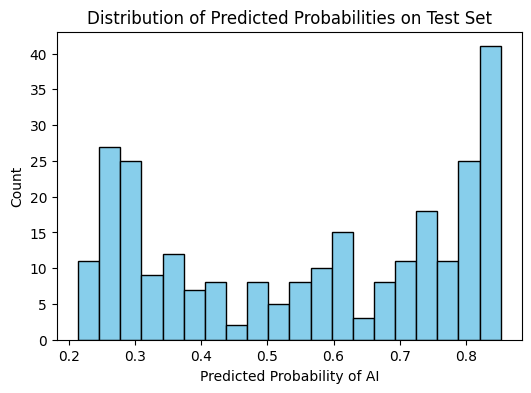

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(test_df['prob_ai'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel("Predicted Probability of AI")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities on Test Set")
plt.show()


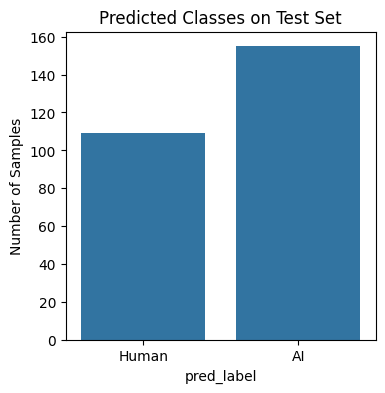

In [ ]:
import seaborn as sns

plt.figure(figsize=(4,4))
sns.countplot(x='pred_label', data=test_df)
plt.xticks([0,1], ['Human', 'AI'])
plt.ylabel("Number of Samples")
plt.title("Predicted Classes on Test Set")
plt.show()


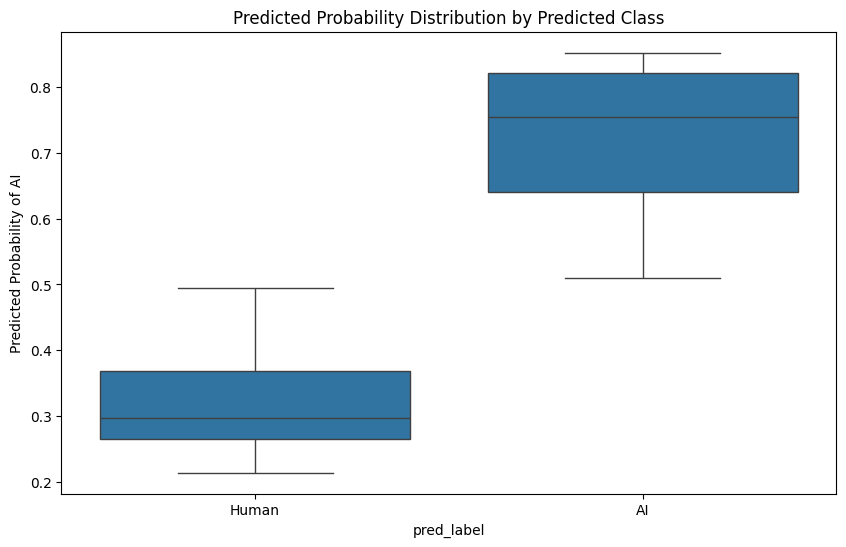

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='pred_label', y='prob_ai', data=test_df)
plt.xticks([0,1], ['Human', 'AI'])
plt.ylabel("Predicted Probability of AI")
plt.title("Predicted Probability Distribution by Predicted Class")
plt.show()


In [ ]:
# Make sure your test_df has these columns:
# 'id'  -> from test.csv
# 'pred_label' -> model's predicted labels (0 or 1)

submission_df = test_df[['id']].copy()
submission_df['is_cheating'] = test_df['pred_label'].astype(int)

# Save submission CSV
submission_path = "/content/drive/MyDrive/mercor/submission.csv"
submission_df.to_csv(submission_path, index=False)

print("✅ Submission file saved to:", submission_path)
submission_df.head()


✅ Submission file saved to: /content/drive/MyDrive/mercor/submission.csv


,id,is_cheating
0,scr_81822029c661,1
1,scr_52efb19e0ea9,1
2,scr_8fc0f33c559e,1
3,scr_bac3f5d3aa12,0
4,scr_adfbe009984d,0


In [ ]:
print(submission_df.shape)
print(submission_df.head())


(264, 2)
                 id  is_cheating
0  scr_81822029c661            1
1  scr_52efb19e0ea9            1
2  scr_8fc0f33c559e            1
3  scr_bac3f5d3aa12            0
4  scr_adfbe009984d            0
